In [1]:
# Skip this cell if we are not on Google Colab
try:
    # Mount Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify working directory.
    FOLDERNAME = 'cs231n/project/'
    %cd /content/drive/My\ Drive/$FOLDERNAME

    # Ensure that the Python interpreter of the Colab VM can load python files from
    # within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
except ImportError as e:
    print("Not on Google Colab.")

Not on Google Colab.


## Load dataset and labels

In [2]:
import numpy as np
import os

#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

train_data = np.load(os.path.join(base_dir, 'train_data_pre60.npy'))
train_actions = np.load(os.path.join(base_dir, 'train_actions_pre60.npy'), allow_pickle=True)

val_data = np.load(os.path.join(base_dir, 'val_data_pre60.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre60.npy'), allow_pickle=True)

In [3]:
# reshape data
train_data = np.moveaxis(train_data, 2, -1)
val_data = np.moveaxis(val_data, 2, -1)

In [4]:
print('Training data shape: ', train_data.shape)
print('Training action shape: ', train_actions.shape)
print('Validation data shape: ', val_data.shape)
print('Validation action shape: ', val_actions.shape)

Training data shape:  (1007, 60, 64, 48, 17)
Training action shape:  (1007,)
Validation data shape:  (433, 60, 64, 48, 17)
Validation action shape:  (433,)


In [5]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

<function matplotlib.pyplot.show(close=None, block=None)>

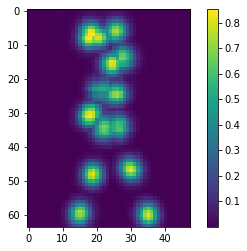

In [6]:
# make sure input dataset is correct
import matplotlib.pyplot as plt

plt.imshow(np.max(train_data[0,-1,:,:,:], axis=-1))
plt.colorbar()
plt.show

In [7]:
print(f"special value may be: {train_data[1,0,:,:,:].max(axis=-1)}")

special value may be: [[-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 ...
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]
 [-10. -10. -10. ... -10. -10. -10.]]


In [8]:
train_data.shape

(1007, 60, 64, 48, 17)

## Model Structure: HR-Net + LSTM

In [9]:
from keras.layers import Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, Masking
from keras import models

# hr-net heatmap: (x, 60, 64, 48, 17)
timesteps = 60
rows, columns, channels = 64, 48, 17
special_value = -10.0

model = models.Sequential()
model.add(Input(shape=(timesteps, rows, columns, channels)))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))

model.add(Masking(mask_value=special_value))
model.add(LSTM(64, dropout=0.25, recurrent_dropout=0.1, return_sequences=False)) # used 64 units
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 60, 52224)         0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 52224)         0         
_________________________________________________________________
masking (Masking)            (None, 60, 52224)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                13385984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

In [10]:
import keras
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=5),
                  keras.callbacks.ModelCheckpoint(
                      filepath='hrnet_lstm_64_dense_d_32_d_8',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=3
                  )]

from keras import optimizers

optimizer_new=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                              decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [11]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=60,
                    callbacks=callbacks_list
                    )

Epoch 1/60
51/51 [==============================] - 51s 927ms/step - loss: 2.0866 - accuracy: 0.1369 - val_loss: 2.0134 - val_accuracy: 0.1871
INFO:tensorflow:Assets written to: hrnet_lstm_64_dense_d_32_d_8/assets
Epoch 2/60
51/51 [==============================] - 39s 764ms/step - loss: 1.9355 - accuracy: 0.2548 - val_loss: 1.8351 - val_accuracy: 0.2517
INFO:tensorflow:Assets written to: hrnet_lstm_64_dense_d_32_d_8/assets
Epoch 3/60
51/51 [==============================] - 39s 765ms/step - loss: 1.7556 - accuracy: 0.3262 - val_loss: 1.7166 - val_accuracy: 0.3464
INFO:tensorflow:Assets written to: hrnet_lstm_64_dense_d_32_d_8/assets
Epoch 4/60
51/51 [==============================] - 39s 767ms/step - loss: 1.6064 - accuracy: 0.4388 - val_loss: 1.5429 - val_accuracy: 0.4042
INFO:tensorflow:Assets written to: hrnet_lstm_64_dense_d_32_d_8/assets
Epoch 5/60
51/51 [==============================] - 39s 766ms/step - loss: 1.4606 - accuracy: 0.5014 - val_loss: 1.4537 - val_accuracy: 0.4042
I

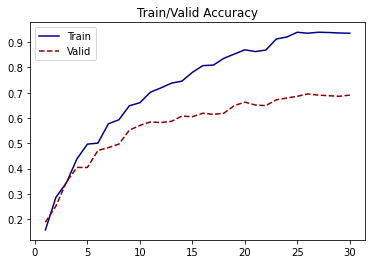

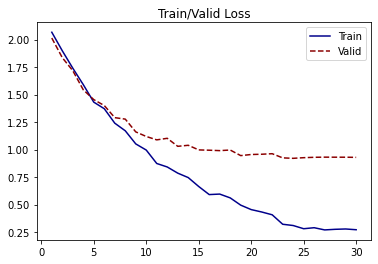

In [12]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkblue')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'darkblue')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

In [13]:
# save training history for visualization
base_dir = '/home/ubuntu'
np.save(os.path.join(base_dir, "hrnet_lstm_64_dense_d_32_d_8"), history.history)

## Evaluate model on test dataset

## Validation dataset

In [4]:
# run this cell to load previously trained model
import numpy as np
import keras
import os

base_dir = '/home/ubuntu'
#model = keras.models.load_model(os.path.join(base_dir, 'cs231n-project/notebooks', 'hrnet_lstm_64_dense_d_32_d_8'))

#val_data = np.load(os.path.join(base_dir, 'val_data_pre60.npy'))data
#val_data = np.moveaxis(val_data, 2, -1)
#val_actions = np.load(os.path.join(base_dir, 'val_actions_pre60.npy'), allow_pickle=True)

In [15]:
val_preds = np.argmax(model.predict(val_data), axis=-1)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

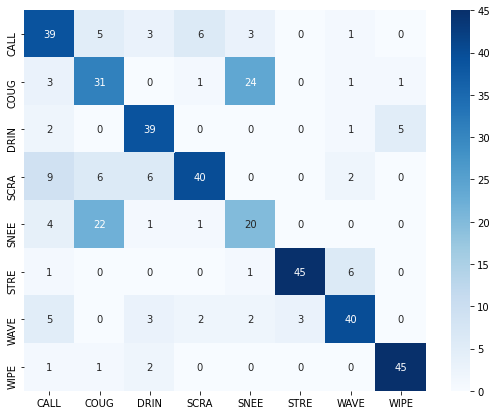

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [17]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

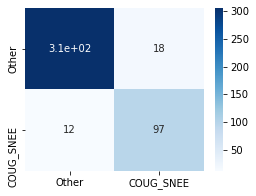

In [18]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [19]:
tn, fp, fn, tp = confusion_matrix.ravel()
prec = tp / (tp + fp)
rec = tp / (tp + fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

0.8434782608695652 0.8899082568807339 0.7637795275590551


## Test dataset

In [1]:
# run this cell to load previously trained model
import numpy as np
import keras
import os

base_dir = '/home/ubuntu'
#model = keras.models.load_model(os.path.join(base_dir, 'cs231n-project/notebooks', 'hrnet_lstm_64_dense_d_32_d_8'))

test_data = np.load(os.path.join(base_dir, 'test_data_pre60.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre60.npy'), allow_pickle=True)

In [2]:
# reshape data
test_data = np.moveaxis(test_data, 2, -1)

In [3]:
print('Test data shape: ', test_data.shape)
print('Test action shape: ', test_actions.shape)

Test data shape:  (480, 60, 64, 48, 17)
Test action shape:  (480,)


In [4]:
test_preds = np.argmax(model.predict(test_data), axis=-1)

mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

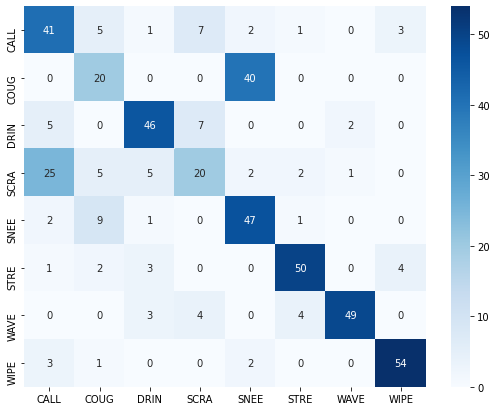

In [5]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [6]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

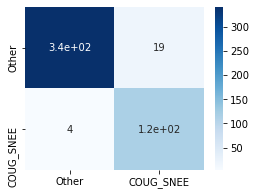

In [7]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [8]:
tn, fp, fn, tp = confusion_matrix.ravel()
prec = tp / (tp + fp)
rec = tp / (tp + fn)
acc = tp / (tp+fp+fn)
print(prec, rec, acc)

0.8592592592592593 0.9666666666666667 0.8345323741007195


## Find examples of failure cases

In [9]:
import pandas as pd

df_videos_test = pd.read_csv('/home/ubuntu/df_videos_test.csv')

In [10]:
df_fail = df_videos_test[test_true != test_preds]

In [11]:
df_fail.head()

,Unnamed: 0,index,video_subject,video_name,action,label
2,2,6,S006,S006_M_DRIN_WLK_FCE.avi,DRIN,0
5,5,16,S002,S002_M_SCRA_STD_FCE.avi,SCRA,0
8,8,23,S005,S005_M_STRE_WLK_LFT.avi,STRE,0
12,12,44,S002,S002_M_COUG_WLK_LFT_HF.avi,COUG,1
13,13,48,S006,S006_M_CALL_WLK_FCE.avi,CALL,0


In [12]:
print(df_fail.groupby('action')['index'].count())

action
CALL    19
COUG    40
DRIN    14
SCRA    40
SNEE    13
STRE    10
WAVE    11
WIPE     6
Name: index, dtype: int64


In [13]:
# COUG:1, SNEE:4
coug_as_snee = df_videos_test[(np.array(test_true) == 1) & (np.array(test_preds) == 4)]
snee_as_coug = df_videos_test[(np.array(test_true) == 4) & (np.array(test_preds) == 1)]
coug_correct = df_videos_test[(np.array(test_true) == 1) & (np.array(test_preds) == 1)]
snee_correct = df_videos_test[(np.array(test_true) == 4) & (np.array(test_preds) == 4)]

In [14]:
coug_as_snee_idx = [357, 286, 341]
snee_correct_idx = [256, 92, 234]

In [15]:
df_videos_test["video_name"][coug_as_snee_idx]

357    S002_M_COUG_STD_RGT.avi
286    S005_M_COUG_STD_RGT.avi
341    S006_M_COUG_STD_RGT.avi
Name: video_name, dtype: object

In [16]:
df_videos_test["video_name"][snee_correct_idx]

256    S002_M_SNEE_STD_RGT.avi
92     S006_M_SNEE_STD_RGT.avi
234    S005_M_SNEE_STD_RGT.avi
Name: video_name, dtype: object

In [42]:
import cv2
import os

# upload sample_video to /content and extract frames
for i in range(3):
    video_name = df_videos_test["video_name"][snee_correct_idx[i]][:-4]
    video_read_path = f'/home/ubuntu/samples/{video_name}.mp4'
    try:
        os.mkdir('/home/ubuntu/frames')
    except:
        pass
    try:
        os.mkdir('/home/ubuntu/frames/' + video_name)
    except:
        pass

    cap=cv2.VideoCapture(video_read_path)
    cap.set(cv2.CAP_PROP_FPS, 20)
    frame_rate=int(cap.get(5))

    while(cap.isOpened()):
        frame_id = cap.get(1)
        ret, frame = cap.read()
        if (ret != True):
            break
        # Extract frames from each second.
        filename = "frame%d.jpg" % frame_id
        cv2.imwrite(os.path.join('/home/ubuntu/frames',  video_name, filename), frame)
    cap.release()

In [24]:
video_name = df_videos_test["video_name"][snee_correct_idx[0]][:-4]
print(video_name)
im = cv2.imread(os.path.join('/home/ubuntu/frames',  video_name, f"frame{20}.jpg"))
bbox = np.load(f'/home/ubuntu/samples/{video_name}_bbox.npy')

S002_M_SNEE_STD_RGT


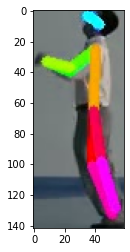

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

coord = list(map(int, bbox[20]))
w = coord[2] - coord[0]
h = coord[3] - coord[1]
img_crop = im[coord[1]:coord[3], coord[0]:coord[2], :]
plt.imshow(img_crop)
plt.show()

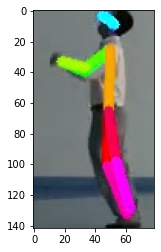

In [26]:
target_w, target_h = 48, 64
ratio = target_h / h
pad = int(target_w - w * ratio) // 2 
img_crop = im[coord[1]:coord[3], (coord[0]-pad):(coord[2]+pad), :]
plt.imshow(img_crop)
plt.show()

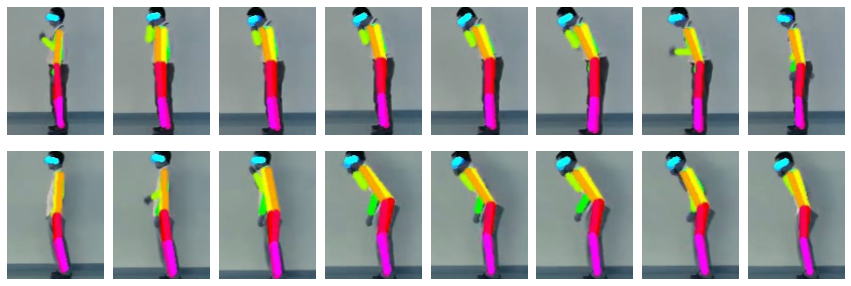

In [66]:
import numpy as np
import matplotlib.pyplot as plt

target_w, target_h = 48, 64
frame_step = 3
frame_starts = [15, 15, 19]
frame_len = 8

f, axarr = plt.subplots(2,frame_len,figsize=(15,6))
plt.subplots_adjust(top = 1, bottom=0, hspace=-0.5, wspace=0.1)
wh_ratio = target_w / target_h

for r in range(1,3):
    for i in range(frame_len):
        video_name = df_videos_test["video_name"][coug_as_snee_idx[r]][:-4]
        im = cv2.imread(os.path.join('/home/ubuntu/frames',  video_name, f'frame{frame_starts[r]+frame_step*i}.jpg'))
        bbox = np.load(f'/home/ubuntu/samples/{video_name}_bbox.npy')
        coord = list(map(int, bbox[frame_starts[r]+frame_step*i]))
        w = coord[2] - coord[0]
        h = coord[3] - coord[1]
        pad = int(h * wh_ratio - w) // 2 
        img_crop = im[coord[1]:coord[3], (coord[0]-pad):(coord[2]+pad), :]
        img_crop = cv2.resize(img_crop, (target_w*2, target_h*2))
        axarr[r-1][i].axis('off')
        axarr[r-1][i].imshow(img_crop)
plt.show()

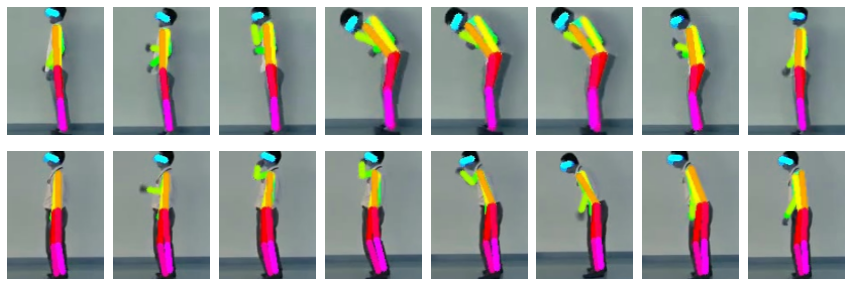

In [65]:
import numpy as np
import matplotlib.pyplot as plt

target_w, target_h = 48, 64
frame_step = 3
frame_starts = [15, 24, 15]
frame_len = 8

f, axarr = plt.subplots(2,frame_len,figsize=(15,6))
plt.subplots_adjust(top = 1, bottom=0, hspace=-0.5, wspace=0.1)
wh_ratio = target_w / target_h

for r in range(1,3):
    for i in range(frame_len):
        video_name = df_videos_test["video_name"][snee_correct_idx[r]][:-4]
        im = cv2.imread(os.path.join('/home/ubuntu/frames',  video_name, f'frame{frame_starts[r]+frame_step*i}.jpg'))
        bbox = np.load(f'/home/ubuntu/samples/{video_name}_bbox.npy')
        coord = list(map(int, bbox[frame_starts[r]+frame_step*i]))
        w = coord[2] - coord[0]
        h = coord[3] - coord[1]
        pad = int(h * wh_ratio - w) // 2 
        img_crop = im[coord[1]:coord[3], (coord[0]-pad):(coord[2]+pad), :]
        img_crop = cv2.resize(img_crop, (target_w*2, target_h*2))
        axarr[r-1][i].axis('off')
        axarr[r-1][i].imshow(img_crop)
plt.show()

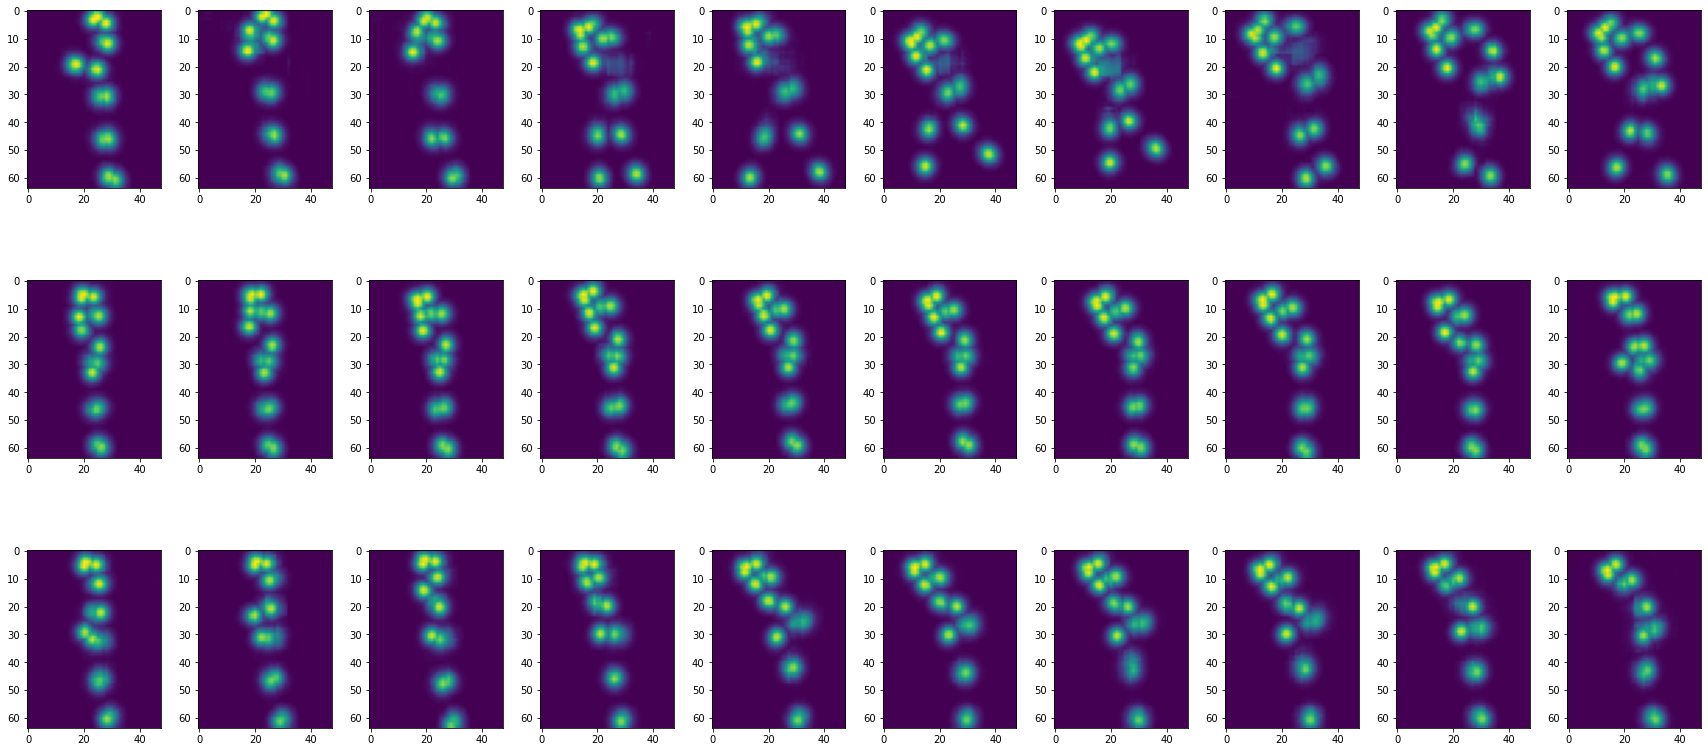

In [143]:
import numpy as np
import matplotlib.pyplot as plt

target_w, target_h = 48, 64
frame_step = 2
frame_start = 20
frame_len = 10

f, axarr = plt.subplots(3,frame_len,figsize=(30,15))
plt.subplots_adjust(top = 1, bottom=0, hspace=-0.5, wspace=0.28)

for r in range(3):
    sample = test_data[coug_as_snee_idx][r]
    for i in range(frame_len):
        axarr[r, i].imshow(np.max(sample[frame_start+frame_step*i,:,:,:], axis=-1))
plt.show()

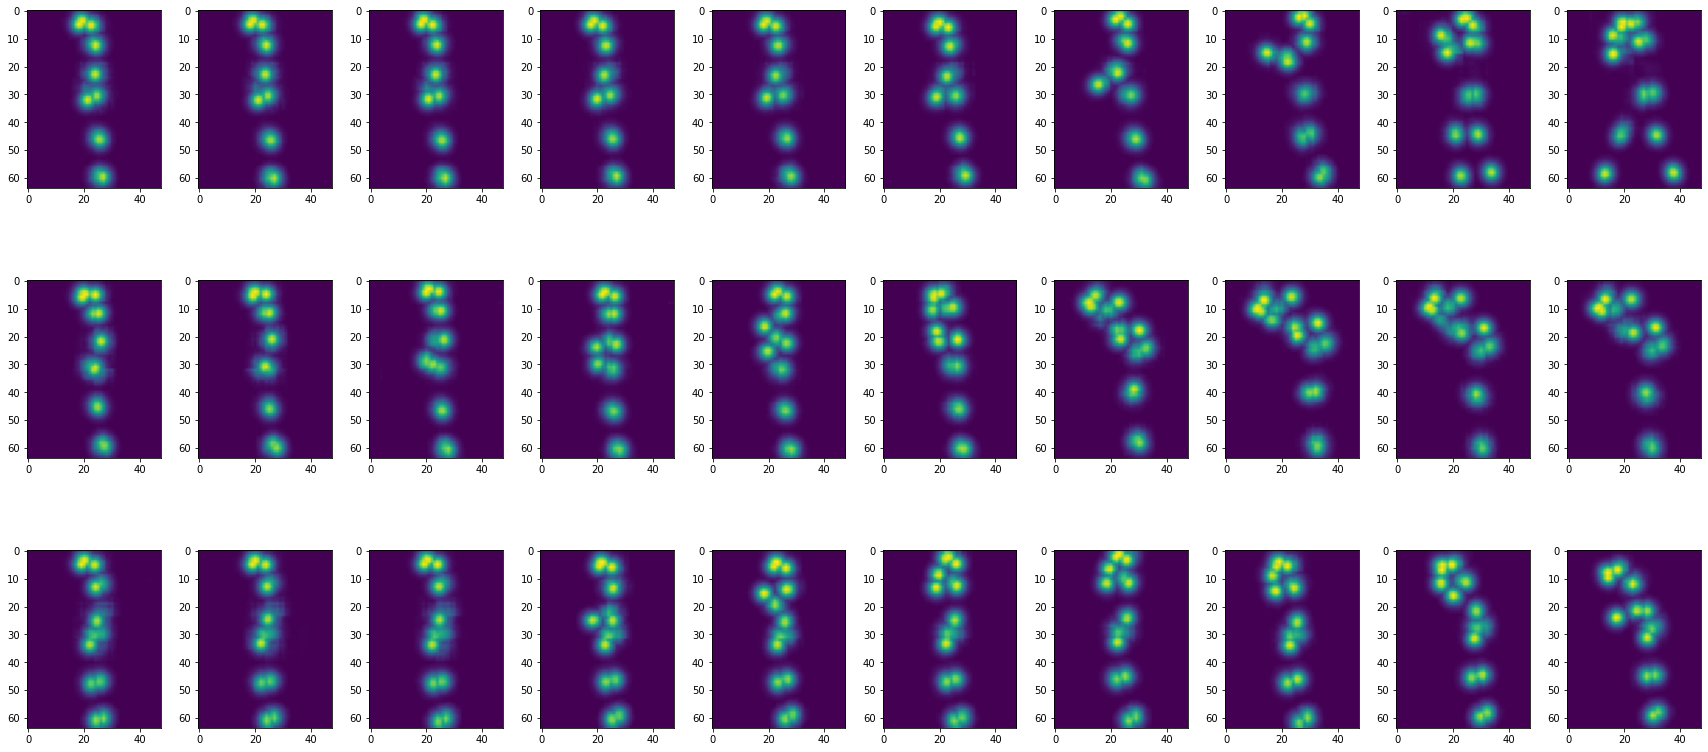

In [145]:
import numpy as np
import matplotlib.pyplot as plt

target_w, target_h = 48, 64
frame_step = 2
frame_start = 20
frame_len = 10

f, axarr = plt.subplots(3,frame_len,figsize=(30,15))
plt.subplots_adjust(top = 1, bottom=0, hspace=-0.5, wspace=0.28)

for r in range(3):
    sample = test_data[snee_correct_idx][r]
    for i in range(frame_len):
        axarr[r, i].imshow(np.max(sample[frame_start+frame_step*i,:,:,:], axis=-1))
plt.show()